In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from Modelevaluator import *
%matplotlib inline

In [2]:
labels = pd.read_csv('labels.csv')
features = pd.read_csv('features.csv')

In [3]:
features.iloc[:,1:9].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           8121 non-null   object 
 1   tags            8116 non-null   object 
 2   loudness        8118 non-null   float64
 3   tempo           8117 non-null   float64
 4   time_signature  8119 non-null   float64
 5   key             8113 non-null   float64
 6   mode            8119 non-null   float64
 7   duration        8119 non-null   float64
dtypes: float64(6), object(2)
memory usage: 508.1+ KB


Impute missing values of time_signature with 4 and mode with 1


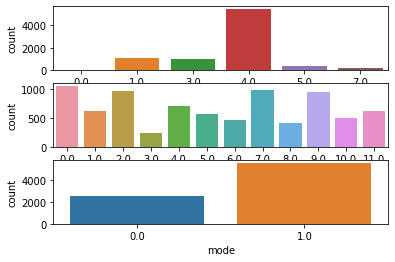

In [4]:
fig, ax =plt.subplots(3,1)
plt.rcParams["figure.figsize"] = [7.00, 6.50]
plt.rcParams["figure.autolayout"] = True

sns.countplot(x='time_signature',data=features,ax=ax[0])
sns.countplot(x='key',data=features,ax=ax[1])
sns.countplot(x='mode',data=features,ax=ax[2])
fig.show()

Impute time_signature with missing value 4.0 (hours probably)

In [5]:
features['time_signature'] = features['time_signature'].fillna(features['time_signature'].mode()[0])

features['key'][features['key'].isna()==True] = features['time_signature'][features['key'].isna()==True].map(dict(features.groupby('time_signature')['key'].agg(lambda x:x.value_counts().index[0])))

In [6]:
features['mode'][features['mode'].isna()==True] = features['key'][features['mode'].isna()==True].map(dict(features.groupby(['key'])['mode'].agg(lambda x:x.value_counts().index[0])))

### Imputing Missing Numerical Values

The sklearn IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

Reference: https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
features[['loudness','tempo','duration']]=imp.fit_transform(features[['loudness','tempo','duration']])

In [8]:
features.iloc[:,1:9].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           8121 non-null   object 
 1   tags            8116 non-null   object 
 2   loudness        8128 non-null   float64
 3   tempo           8128 non-null   float64
 4   time_signature  8128 non-null   float64
 5   key             8128 non-null   float64
 6   mode            8128 non-null   float64
 7   duration        8128 non-null   float64
dtypes: float64(6), object(2)
memory usage: 508.1+ KB


### Imputing Missing Vector Values

In [9]:
imp2 = IterativeImputer(max_iter=10, random_state=0)
features.loc[:,'vect_1':'vect_148']=imp2.fit_transform(features.loc[:,'vect_1':'vect_148'])

### Feature Selection

In [10]:
from scipy.stats import chi2_contingency

print("-----P-Values of two-way Chi-Square Test involving categorical predictors-----")
for i in ['mode','key','time_signature']:
    cont=pd.crosstab(features[i],labels['genre']) #Contingency table
    g, p, dof, expctd = chi2_contingency(cont)
    print(i,": ", p)

-----P-Values of two-way Chi-Square Test involving categorical predictors-----
mode :  0.37843063757776735
key :  0.5225377550043075
time_signature :  0.653536364872702


Strong relationship implied between target column genre and the categorical predictors time_signature, key and mode.

In [11]:
features[['loudness','tempo','duration']].corr()

,loudness,tempo,duration
loudness,1.000000,0.212773,0.031177
tempo,0.212773,1.000000,-0.038572
duration,0.031177,-0.038572,1.000000


No multicollinearity between duration, tempo and loudness.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [13]:
vif=calc_vif(features.loc[:,'vect_1':'vect_148'])
vif[vif['VIF']>20]

,variables,VIF
0,vect_1,364.503793
15,vect_16,21.976124
17,vect_18,38.410831
19,vect_20,28.939634
21,vect_22,45.078644
...,...,...
143,vect_144,813.828408
144,vect_145,704.506281
145,vect_146,451.028298
146,vect_147,37.376576


Most of the vector features (above 120) have high variances.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

In [14]:


x_vectors=pca_apply(features)
x_vectors.head()

,pca1,pca2,pca3,pca4,pca5
0,-4.477561,5.039648,-0.034835,-1.246566,1.818353
1,6.565589,-7.818068,-1.011638,-2.166262,-2.990009
2,4.155065,-3.313893,-0.634046,6.953128,1.965094
3,-3.042738,4.914606,-0.070573,-3.489479,-7.514606
4,5.127166,5.574076,-0.280892,-1.894432,2.710766


In [15]:
labels['genre'].value_counts()

classic pop and rock     1684
folk                     1665
metal                    1209
soul and reggae           988
punk                      981
pop                       731
dance and electronica     523
jazz and blues            347
Name: genre, dtype: int64

In [16]:
#Rank job categories by occurences of count
job_rankings = labels.groupby('genre')['trackID'].count().rank(ascending=False).reset_index()
job_rankings

,genre,trackID
0,classic pop and rock,1.0
1,dance and electronica,7.0
2,folk,2.0
3,jazz and blues,8.0
4,metal,3.0
5,pop,6.0
6,punk,5.0
7,soul and reggae,4.0


In [17]:
class_weights = dict(zip(labels['genre'].unique(),np.ones(len(labels['genre'].unique()))))

for i in job_rankings.itertuples():
  if i[2]>6:
    class_weights[i[1]]= 3
  elif 4<=i[2]<=6:
    class_weights[i[1]]= 2
  #else:
    #class_weights[i[1]]= 1.2
        
class_weights

{'metal': 1.0,
 'folk': 1.0,
 'jazz and blues': 3,
 'soul and reggae': 2,
 'classic pop and rock': 1.0,
 'punk': 2,
 'dance and electronica': 3,
 'pop': 2}

### Training Algorithm

In [18]:


test = pd.read_csv('test.csv')
x=pd.concat([features.loc[:,'loudness':'duration'], x_vectors],axis=1)
y=labels['genre']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)

In [19]:
#Cross Validate Logistic Regression Classifier
model = XGBClassifier(max_depth=8, learning_rate=1.8, n_estimators=5, n_jobs=-1,
                      num_iterations=10000,
                      objective='multi:softprob',
                      metric='multiclass',
                    eval_metric='mlogloss',
                     boosting='gbdt',scale_pos_weight=class_weights)
mod = Modelevaluator(model,x_train, x_test, y_train, y_test,test)

In [20]:
mod.cross_evaluation(cv_int=5)

[15:54:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:54:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:54:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", 

[15:54:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




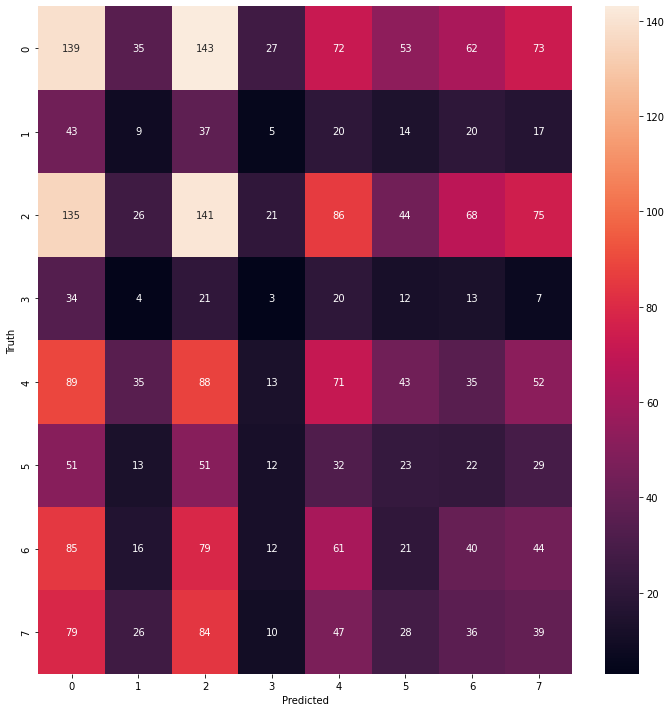

[15:54:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


                       precision    recall  f1-score   support

 classic pop and rock       0.21      0.23      0.22       604
dance and electronica       0.05      0.05      0.05       165
                 folk       0.22      0.24      0.23       596
       jazz and blues       0.03      0.03      0.03       114
                metal       0.17      0.17      0.17       426
                  pop       0.10      0.10      0.10       233
                 punk       0.14      0.11      0.12       358
      soul and reggae       0.12      0.11      0.11       

In [21]:
mod.confusion_matrix()
mod.classification_report()

In [22]:
mod.plot_feature_importances()

pca5              0.099893
pca4              0.097863
duration          0.095283
pca2              0.094515
pca1              0.094056
tempo             0.092883
loudness          0.092120
pca3              0.090891
time_signature    0.087025
key               0.084212
mode              0.071259
dtype: float32

In [23]:
mod.save_model('xgbclassifier.pkl')

In [24]:
test_vectors = pca_apply(test)
test = pd.concat([test['title'],test.loc[:,'loudness':'duration'], test_vectors],axis=1)
test['genre'] = mod.generate_predictions()
test.head()

,title,loudness,tempo,time_signature,key,mode,duration,pca1,pca2,pca3,pca4,pca5,genre
0,You Get What You Give,-5.672,113.941,4,2,1,300.82567,-1.144715,6.116385,1.765811,-1.468044,0.266237,pop
1,Greedee,-7.931,102.062,4,11,1,259.60444,-2.178923,8.924952,2.493993,-0.223448,-1.943375,pop
2,Wonderful World,-16.714,85.513,5,8,0,128.36526,-4.667750,-2.351404,0.693398,-4.196365,-0.167289,classic pop and rock
3,Michoacan,-13.346,124.447,4,3,1,180.37506,-4.577429,-1.441989,-0.926254,-2.476596,-2.970399,classic pop and rock
4,HUSTLER,-9.365,127.018,4,7,1,483.26485,7.457590,-5.626451,3.329290,-0.839178,-5.198753,classic pop and rock


In [25]:
test[['title','genre']].to_csv('Prediction.csv',index=False)